In [ ]:
# default_exp core

# Core functionality

> Memory profiling.

In [ ]:
#hide
from nbdev.showdoc import *

## Memory hooks

Inspired by https://www.sicara.ai/blog/2019-28-10-deep-learning-memory-usage-and-pytorch-optimization-tricks

In [ ]:
#export
import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda.amp as amp
from fastai.callback.all import Hooks, ShortEpochCallback, HookCallback, has_params
from fastai.basics import *

In [ ]:
#export
def _generate_mem_hook(mem_log, idx, hook_type, experiment):
    "Hook function generator"
    def hook(m, *args):
        inp_shape = args[0][0].shape
        out_shape = args[1][0].shape if len(args)>1 else None
        if len(mem_log) == 0: call_idx = 0
        else: call_idx = mem_log[-1]["call_idx"] + 1
        mem_all = torch.cuda.memory_allocated()
        mem_reserved = torch.cuda.memory_reserved()
        max_all = torch.cuda.max_memory_allocated()
        torch.cuda.synchronize()
        mem_log.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(m).__name__,
            'experiment': experiment,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_reservd': mem_reserved,
            'max_all': max_all,
            'input_shape': inp_shape,
            'output_shape': out_shape,
        })
    return hook

In [ ]:
#export
class MemHooks(Hooks):
    "Creates hooks for logging memory stats"
    def __init__(self, ms, name=None):
        self.hooks = []
        self.mem_log = []
        for i, m in enumerate(ms): self.register_memory_hooks(m, i, name=name)

    def register_memory_hooks(self, m, i, name=None):
        fs = {'pre':m.register_forward_pre_hook,
              'fwd':m.register_forward_hook,
              'bwd':m.register_backward_hook}
        for hook_type in ['pre', 'fwd', 'bwd']:
            self.hooks.append(fs[hook_type](_generate_mem_hook(self.mem_log, i, hook_type, name)))

## Memory profiling functionality

In [ ]:
#export
def plot_log(mem_log:pd.DataFrame):
    plt.plot(mem_log['call_idx'], mem_log['mem_all']/1024)
    plt.ylabel('Memory allocated (Kb)');

In [ ]:
#export
def plot_logs(*mem_logs):
    fig, ax = plt.subplots(1,1, figsize=(10,4))
    legend = []
    for log in mem_logs:
        plt.plot(log['mem_all']/1024)
        legend += [log.loc[0, 'experiment']]
    if len(mem_logs) > 1: ax.legend(legend)
    plt.ylabel('Memory allocated (Kb)')
    plt.show()

In [ ]:
#export
def memprofile(model:nn.Module, xb:Tensor, yb:Tensor, loss_func=CrossEntropyLossFlat(), plot=True, label=None, fp16=False):
    "Records memory stats for one forward-and-backward pass through the model with batch (xb, yb)"
    def forward_and_loss():
        out = model(xb)
        return loss_func(out, yb)
    label = ifnone(label, type(model).__name__)
    device = xb.device
    model.to(device)
    prealloc = torch.cuda.memory_allocated()
    with MemHooks(flatten_model(model), label) as h:
        if fp16: forward_and_loss = amp.autocast()(forward_and_loss)
        loss = forward_and_loss()
        loss.backward()
        model.zero_grad(set_to_none=True)
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    mem_log['mem_all'] = mem_log['mem_all'] - prealloc
    if plot:
        plot_log(mem_log)
    return mem_log

In [ ]:
#export
def simple_model(ni=100, no=2, n=4):
    layers = [nn.Linear(ni, ni) for i in range(n)] + [nn.Linear(ni,no)]
    return nn.Sequential(*layers)

In [ ]:
#cuda
ni = 100
no = 2
xb, yb = torch.randn(32, ni).cuda(), torch.randint(no, (32,)).cuda()

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,max_all,input_shape,output_shape
0,0,0,Linear,Sequential,pre,0,2097152,178688,"(32, 100)",None
1,0,1,Linear,Sequential,fwd,12800,2097152,191488,"(32, 100)","(100,)"
2,1,2,Linear,Sequential,pre,12800,2097152,191488,"(32, 100)",None
3,1,3,Linear,Sequential,fwd,25600,2097152,204288,"(32, 100)","(100,)"
4,2,4,Linear,Sequential,pre,25600,2097152,204288,"(32, 100)",None
5,2,5,Linear,Sequential,fwd,38400,2097152,217088,"(32, 100)","(100,)"
6,3,6,Linear,Sequential,pre,38400,2097152,217088,"(32, 100)",None
7,3,7,Linear,Sequential,fwd,51200,2097152,229888,"(32, 100)","(100,)"
8,4,8,Linear,Sequential,pre,51200,2097152,229888,"(32, 100)",None
9,4,9,Linear,Sequential,fwd,51712,2097152,230400,"(32, 100)","(2,)"


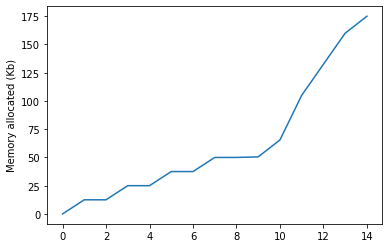

In [ ]:
#cuda
mem_log1 = memprofile(simple_model(), xb, yb)
mem_log1

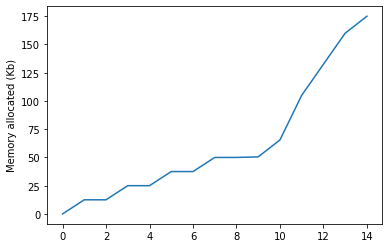

In [ ]:
#hide
#skip
plot_log(mem_log1)

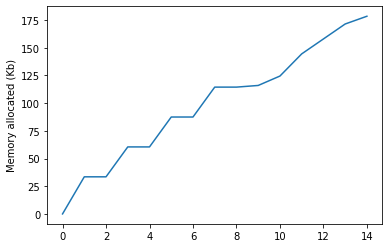

In [ ]:
#hide
#cuda
with torch.cuda.amp.autocast():
    mem_log = memprofile(simple_model(), xb, yb)

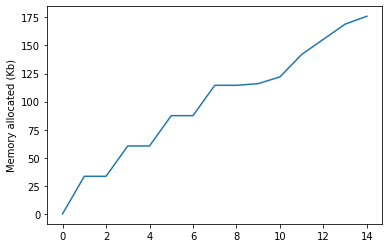

In [ ]:
#cuda
mem_log2 = memprofile(simple_model(), xb, yb, fp16=True)

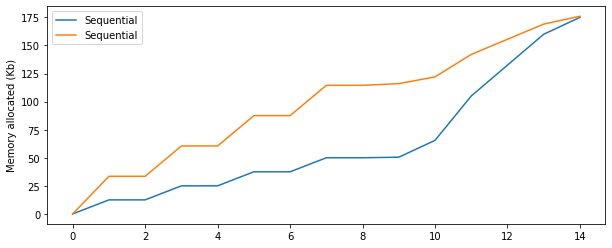

In [ ]:
#hide
#cuda
plot_logs(mem_log1, mem_log2)

In [ ]:
#export
class BreakFitCallback(Callback):
    "Cancels fit after one batch before weight update"
    def before_step(self):
        self.model.zero_grad(set_to_none=True)
        raise CancelStepException
    def after_step(self):
        raise CancelBatchException
    def after_batch(self):
        print('Fit canceled')
        raise CancelFitException

In [ ]:
#export
@patch
def profile_memory(self:Learner, plot=True):
    """
    Records memory stats for single forward-and-backward pass
    """
    with MemHooks(flatten_model(self.model), type(self.model).__name__) as h:
        prealloc = torch.cuda.memory_allocated()
        with self.added_cbs(BreakFitCallback()), self.no_logging():
            self.fit(1)
        mem_log = pd.DataFrame(h.mem_log, copy=True)
    mem_log['mem_all'] = mem_log['mem_all'] - prealloc
    if plot:
        plot_log(mem_log)
        
    return mem_log

In [ ]:
#export
def simple_dls():
    train = [(torch.randn(100), torch.randint(2, (1,))) for _ in range(800)]
    valid = [(torch.randn(100), torch.randint(2, (1,))) for _ in range(200)]
    return DataLoaders.from_dsets(train, valid, bs=16, device='cuda')

In [ ]:
#hide
#cuda
dls = simple_dls()
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat())
w0 = learn.model[0].weight.detach().cpu().clone()
with learn.added_cbs(BreakFitCallback()):
    learn.fit(1)
w1 = learn.model[0].weight.detach().cpu().clone()
assert ((w1 == w0).all()), 'Weights were changed during memory profiling'
assert (learn.model[0].weight.grad is None), 'Grads not set to None'

epoch,train_loss,valid_loss,time


Fit canceled


Fit canceled


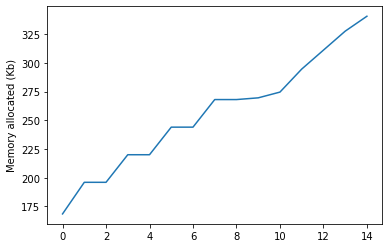

In [ ]:
#hide
#cuda
dls = simple_dls()
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat()).to_fp16()
mem_log1 = learn.profile_memory()

Fit canceled


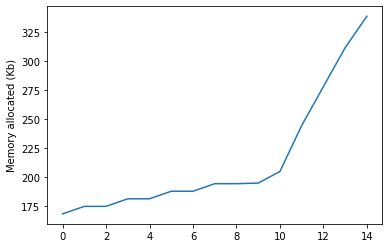

In [ ]:
#cuda
dls = simple_dls()
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat())
mem_log1 = learn.profile_memory()

In [ ]:
#cuda
mem_log1

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,max_all,input_shape,output_shape
0,0,0,Linear,Sequential,pre,172544,2097152,379904,"(16, 100)",None
1,0,1,Linear,Sequential,fwd,179200,2097152,379904,"(16, 100)","(100,)"
2,1,2,Linear,Sequential,pre,179200,2097152,379904,"(16, 100)",None
3,1,3,Linear,Sequential,fwd,185856,2097152,379904,"(16, 100)","(100,)"
4,2,4,Linear,Sequential,pre,185856,2097152,379904,"(16, 100)",None
5,2,5,Linear,Sequential,fwd,192512,2097152,379904,"(16, 100)","(100,)"
6,3,6,Linear,Sequential,pre,192512,2097152,379904,"(16, 100)",None
7,3,7,Linear,Sequential,fwd,199168,2097152,379904,"(16, 100)","(100,)"
8,4,8,Linear,Sequential,pre,199168,2097152,379904,"(16, 100)",None
9,4,9,Linear,Sequential,fwd,199680,2097152,379904,"(16, 100)","(2,)"


Similar to fastai `Hooks` class, `MemHooks` can be used as context manager:

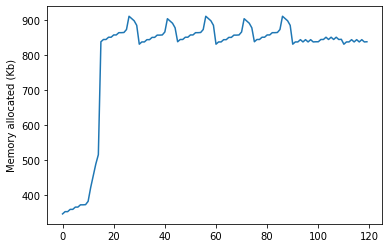

In [ ]:
#slow
with MemHooks(flatten_model(learn.model), 'test') as h:
    learn.fit(1, 1e-3, cbs=ShortEpochCallback(pct=0.1))
mem_log2 = pd.DataFrame(h.mem_log, copy=True)
plot_log(mem_log2)

## Memory callback

In [ ]:
#export
class MemStatsCallback(HookCallback):
    "Registers memory hooks on modules in `ms`"
    def __init__(self, ms=None, label=None, remove_end=True):
        store_attr()
        self.prealloc = torch.cuda.memory_allocated()
        self.every = None
    
    def _register(self): self.hooks = MemHooks(self.ms, name=self.label)
    
    def before_fit(self):
        "Register `self.hooks` on `self.ms`."
        if self.ms is None: self.ms = [m for m in flatten_model(self.model) if has_params(m)]
        if self.every is None: self._register()
        
    def after_fit(self):
        self.stats = pd.DataFrame(self.hooks.mem_log, copy=True)
        self.stats['mem_all'] = self.stats['mem_all'] - self.prealloc
        if self.remove_end: self._remove()
    
    def plot(self): plot_log(self.stats)

`MemStatsCallback` can be used to profile memory usage during `fit`:

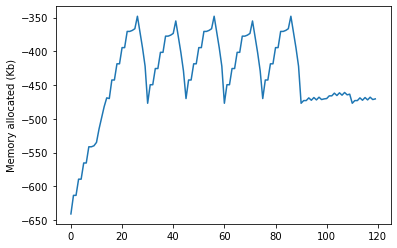

In [ ]:
#cuda
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback(), opt_func=SGD).to_fp16()
learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])
learn.mem_stats.plot()

For example it might be used to compare memory allocation for different optimizers:

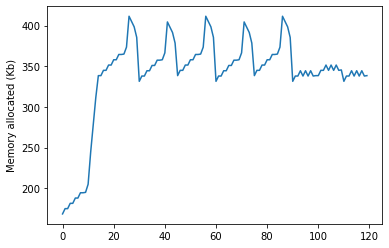

In [ ]:
#cuda
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback(), opt_func=SGD)
learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])
learn.mem_stats.plot()

In [ ]:
#cuda
learn.mem_stats.stats

,layer_idx,call_idx,layer_type,experiment,hook_type,mem_all,mem_reservd,max_all,input_shape,output_shape
0,0,0,Linear,None,pre,172544,2097152,1007616,"(16, 100)",None
1,0,1,Linear,None,fwd,179200,2097152,1007616,"(16, 100)","(100,)"
2,1,2,Linear,None,pre,179200,2097152,1007616,"(16, 100)",None
3,1,3,Linear,None,fwd,185856,2097152,1007616,"(16, 100)","(100,)"
4,2,4,Linear,None,pre,185856,2097152,1007616,"(16, 100)",None
...,...,...,...,...,...,...,...,...,...,...
115,2,115,Linear,None,fwd,352768,2097152,1007616,"(16, 100)","(100,)"
116,3,116,Linear,None,pre,346112,2097152,1007616,"(16, 100)",None
117,3,117,Linear,None,fwd,352768,2097152,1007616,"(16, 100)","(100,)"
118,4,118,Linear,None,pre,346112,2097152,1007616,"(16, 100)",None


When using Adam more memory is allocated:

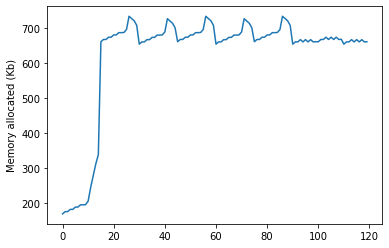

In [ ]:
#cuda
learn = Learner(dls, simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback(), opt_func=Adam)
learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])
learn.mem_stats.plot()

In [ ]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
